In [4]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'


# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')


# Display the first few rows of each dataset
train_data.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
1,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_informative,informative,not_informative,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
3,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
4,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive


In [5]:
import pandas as pd
import os
import random
from PIL import Image
import numpy as np
from tqdm import tqdm

# Config
λ = 0.5
random.seed(42)
image_size = (224, 224)
save_dir = 'data_image/augmented_images'
output_tsv = 'augmented_data.tsv'

# Prepare folder
os.makedirs(save_dir, exist_ok=True)

# Load dataset
df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')

# Filter only positive samples
positive_df = df[df['label_text_image'] == 'Positive'].reset_index(drop=True)
print(f"Positive samples: {len(positive_df)}")

# Group by label
label_groups = positive_df.groupby('label')

augmented_data = []
counter = 0

# For each label group, make random pairs
for label, group in label_groups:
    group = group.reset_index(drop=True)
    indices = list(range(len(group)))
    random.shuffle(indices)

    # Make pairs (i, i+1)
    for i in range(0, len(indices) - 1, 2):
        row1 = group.iloc[indices[i]]
        row2 = group.iloc[indices[i + 1]]

        try:
            img1 = Image.open(row1['image']).convert('RGB').resize(image_size)
            img2 = Image.open(row2['image']).convert('RGB').resize(image_size)
        except Exception as e:
            print(f"Image load error: {e}")
            continue

        # Mixup images
        img1_np = np.array(img1, dtype=np.float32)
        img2_np = np.array(img2, dtype=np.float32)
        mixed_img_np = λ * img1_np + (1 - λ) * img2_np
        mixed_img_np = np.clip(mixed_img_np, 0, 255).astype(np.uint8)
        mixed_img = Image.fromarray(mixed_img_np)

        # Save new image
        new_img_name = f"aug_{counter}.jpg"
        new_img_path = os.path.join(save_dir, new_img_name)
        mixed_img.save(new_img_path)

        # Combine text
        new_text = row1['tweet_text'].strip() + ' ' + row2['tweet_text'].strip()

        # Save row
        augmented_data.append({
            'tweet_text': new_text,
            'image': new_img_path,
            'label': label
        })
        counter += 1

# Save to TSV
aug_df = pd.DataFrame(augmented_data)
aug_df.to_csv(output_tsv, sep='\t', index=False)

print(f"✅ Saved {len(aug_df)} augmented samples to {output_tsv}")


Positive samples: 9601


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✅ Saved 4800 augmented samples to augmented_data.tsv


In [8]:
import pandas as pd

# Load the augmented dataset
train_file_path = 'augmented_data.tsv'
train_data = pd.read_csv(train_file_path, sep='\t')

# Add new column
train_data['label_text_image'] = 'Positive'

# Save updated TSV
train_data.to_csv(train_file_path, sep='\t', index=False)

# Show first few rows
train_data.head()


,tweet_text,image,label,label_text_image
0,Swells from #hurricaneMaria rolling up along o...,data_image/augmented_images\aug_0.jpg,informative,Positive
1,Helping Employees Recover from Harvey and Irma...,data_image/augmented_images\aug_1.jpg,informative,Positive
2,San Antonio effort for Harvey relief seeks dri...,data_image/augmented_images\aug_2.jpg,informative,Positive
3,"Wildfires are very common, unfortunately, in A...",data_image/augmented_images\aug_3.jpg,informative,Positive
4,Trailers could house those displaced by fires ...,data_image/augmented_images\aug_4.jpg,informative,Positive


Train Epoch 1/5:  94%|█████████▎| 843/901 [04:05<00:14,  3.97it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val Epoch 1/5: 100%|██████████| 99/99 [00:25<00:00,  3.88it/s]


Epoch 1 | Train Acc: 75.74%, Val Acc: 89.89%


Val Epoch 2/5: 100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


Epoch 2 | Train Acc: 92.83%, Val Acc: 92.05%


Val Epoch 3/5: 100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


Epoch 3 | Train Acc: 94.09%, Val Acc: 91.10%


Val Epoch 4/5: 100%|██████████| 99/99 [00:25<00:00,  3.95it/s]


Epoch 4 | Train Acc: 94.56%, Val Acc: 92.88%


Val Epoch 5/5: 100%|██████████| 99/99 [00:40<00:00,  2.45it/s]


Epoch 5 | Train Acc: 95.07%, Val Acc: 93.45%


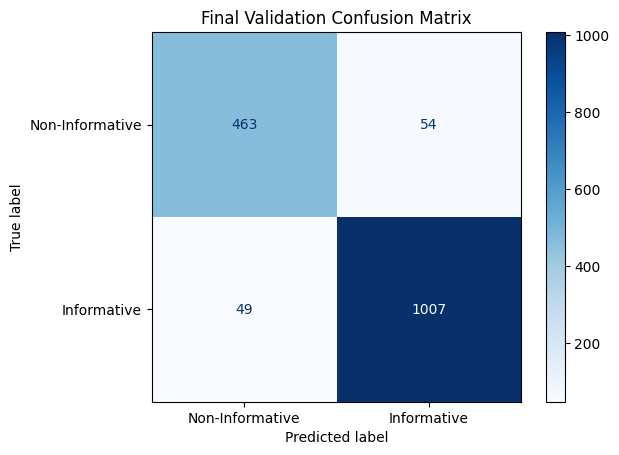

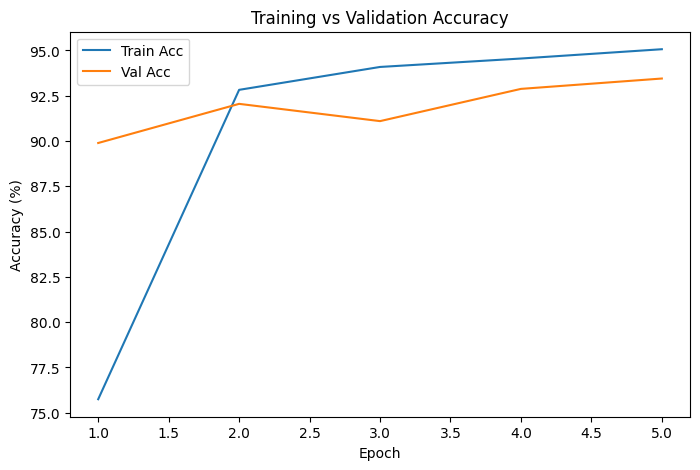

Training & validation complete.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F

# -------------------- Dataset --------------------
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_length=77):
        self.data = dataframe
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['tweet_text']
        image_path = self.image_dir + self.data.iloc[idx]['image']
        label = 1 if self.data.iloc[idx]['label'] == 'informative' else 0

        image = Image.open(image_path).convert("RGB")
        text_inputs = self.processor.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        image_inputs = self.processor(images=image, return_tensors="pt")["pixel_values"]

        return {
            'input_ids': text_inputs.input_ids.squeeze(0),
            'attention_mask': text_inputs.attention_mask.squeeze(0),
            'pixel_values': image_inputs.squeeze(0)
        }, torch.tensor(label, dtype=torch.long)

# -------------------- CoCoOp-Style Contrastive Classifier --------------------
class CoCoOpContrastive(nn.Module):
    def __init__(self, clip_model, processor, prompt_length=4, meta_hidden=512, temperature=1.0):
        super().__init__()
        self.clip = clip_model
        self.processor = processor
        for param in self.clip.parameters():
            param.requires_grad = False

        D = self.clip.config.projection_dim
        self.prompt_length = prompt_length
        self.token_emb = self.clip.text_model.embeddings.token_embedding
        self.pos_emb = self.clip.text_model.embeddings.position_embedding
        self.ln_final = self.clip.text_model.final_layer_norm
        self.text_proj = self.clip.text_projection

        # learnable base prompts
        self.prompt_tokens = nn.Parameter(torch.randn(prompt_length, D))
        # meta-net for adaptive delta
        self.meta_net = nn.Sequential(
            nn.Linear(D*2, meta_hidden),
            nn.ReLU(),
            nn.Linear(meta_hidden, prompt_length * D)
        )
        self.temperature = nn.Parameter(torch.tensor(temperature))
        self.class_names = ["Non-Informative", "Informative"]

        # tokenize class names once using processor.tokenizer
        enc = self.processor.tokenizer(
            [f"a photo of a {c}" for c in self.class_names],
            padding='longest',
            truncation=True,
            return_tensors='pt'
        )
        self.register_buffer('class_input_ids', enc.input_ids)
        self.register_buffer('class_attention_mask', enc.attention_mask)

    def forward(self, inputs):
        # extract base features
        image_feat = self.clip.get_image_features(inputs['pixel_values'])  # [B, D]
        text_feat = self.clip.get_text_features(
            inputs['input_ids'], inputs['attention_mask']
        )  # [B, D]

        # compute adaptive prompt tokens
        meta_in = torch.cat([image_feat, text_feat], dim=-1)
        delta = self.meta_net(meta_in).view(
            -1, self.prompt_length, image_feat.size(-1)
        )
        prompts = self.prompt_tokens.unsqueeze(0) + delta  # [B, prompt_length, D]

        B = prompts.size(0)
        C = len(self.class_names)
        # expand prompts and class token sequences
        prompts_exp = prompts.unsqueeze(1).expand(B, C, -1, -1).reshape(
            B*C, self.prompt_length, -1
        )
        cls_ids = self.class_input_ids.unsqueeze(0).expand(B, -1, -1).reshape(B*C, -1)
        cls_emb = self.token_emb(cls_ids)

        # combine prompts + class tokens
        full_emb = torch.cat([prompts_exp, cls_emb], dim=1)  # [B*C, L', D]
        Lp = full_emb.size(1)
        pos_ids = torch.arange(Lp, device=full_emb.device).unsqueeze(0)
        full = full_emb + self.pos_emb(pos_ids)

        # encode through text transformer
        out = self.clip.text_model.encoder(full)[0]
        cls_out = out[:, 0]
        ln = self.ln_final(cls_out)
        text_emb = self.text_proj(ln).view(B, C, -1)  # [B, C, D]

        # contrastive logits
        logits = F.cosine_similarity(
            image_feat.unsqueeze(1), text_emb, dim=-1
        ) * self.temperature
        return logits  # [B, C]

# -------------------- Training & Validation --------------------
if __name__ == '__main__':
    # Setup processor and base CLIP
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    # Load original and augmented datasets
    orig_train = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
    orig_val   = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')
    aug_train  = pd.read_csv('augmented_data.tsv', sep='\t')

    # Ensure augmented has label_text_image
    aug_train['label_text_image'] = 'Positive'

    # Combine original positive and augmented data
    orig_train = orig_train[orig_train['label_text_image'] == 'Positive']
    train_df = pd.concat([orig_train, aug_train], ignore_index=True)
    val_df   = orig_val[orig_val['label_text_image'] == 'Positive']

    image_dir = ''  # adjust if needed

    # Create datasets and loaders
    train_ds = MultimodalDataset(train_df, image_dir, processor)
    val_ds   = MultimodalDataset(val_df, image_dir, processor)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=16)

    # Initialize model
    model = CoCoOpContrastive(clip_model, processor)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Optimizer & loss
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)
    loss_fn   = nn.CrossEntropyLoss()

    train_acc_history = []
    val_acc_history   = []
    epochs = 5

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0; train_total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{epochs}"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_fn(logits, labels)
            loss.backward(); optimizer.step()
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
        train_acc = train_correct / train_total * 100
        train_acc_history.append(train_acc)

        model.eval()
        val_correct = 0; val_total = 0; all_labels = [];
        all_preds = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{epochs}"):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                logits = model(inputs)
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                all_labels.extend(labels.cpu().tolist())
                all_preds.extend(preds.cpu().tolist())
        val_acc = val_correct / val_total * 100
        val_acc_history.append(val_acc)
        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Final Validation Confusion Matrix")
    plt.show()

    # Accuracy curves
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_acc_history, label='Train Acc')
    plt.plot(range(1, epochs+1), val_acc_history, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)')
    plt.title('Training vs Validation Accuracy'); plt.legend(); plt.show()

    print("Training & validation complete.")


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy : 93.61%
Test Precision: 94.38%
Test Recall   : 96.21%
Test F1 Score : 95.29%


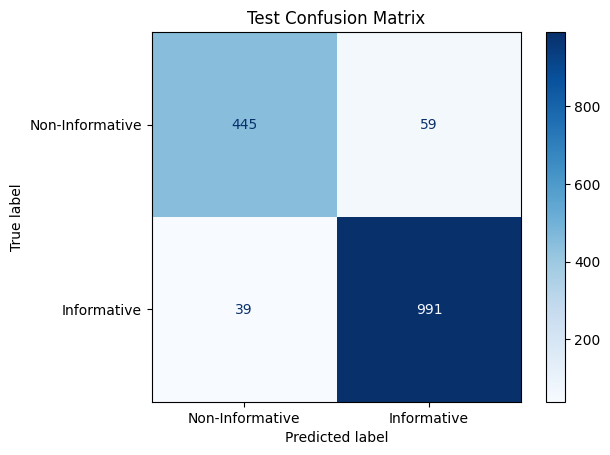

In [9]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay



# -------------------- Testing & Metrics Only --------------------
# Load and filter the test dataset
test_df = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv', sep='\t'
)
test_df_positive = test_df[test_df['label_text_image'] == 'Positive']

# Prepare test DataLoader
test_dataset = MultimodalDataset(test_df_positive, image_dir, processor)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Evaluate using the in-memory trained model
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        logits = model(inputs)           # [B, 2]
        preds  = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

# Compute metrics
acc  = accuracy_score(all_labels, all_preds) * 100
prec = precision_score(all_labels, all_preds, zero_division=0) * 100
rec  = recall_score(all_labels, all_preds, zero_division=0) * 100
f1   = f1_score(all_labels, all_preds, zero_division=0) * 100

print(f"Test Accuracy : {acc:.2f}%")
print(f"Test Precision: {prec:.2f}%")
print(f"Test Recall   : {rec:.2f}%")
print(f"Test F1 Score : {f1:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=model.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()